See README.md for installs, environment setup

In [1]:
import os
import sys
from multiprocessing import Pool
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_datareader as pdr
import quandl
import xlrd

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# https://www.cvxpy.org/install/index.html
import cvxpy as cp

# create an env var QUANDL_TOKEN=xxxxxx
quandl_token = os.getenv('QUANDL_TOKEN')

# set seed for reproducibility
np.random.seed(2347)

print("%-20s %s" % ('python', ".".join(map(str, sys.version_info[:3]))))
print("%-20s %s" % ("numpy", np.__version__))
print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("pandas-datareader", pdr.__version__))
# print("%-20s %s" % ("xlrd", xlrd.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("matplotlib", matplotlib.__version__))
print("%-20s %s" % ("cvxpy", cp.__version__))
print("%-20s %s" % ("quandl", quandl.version.VERSION))


python               3.7.10
numpy                1.19.2
pandas               1.1.3
pandas-datareader    0.9.0
seaborn              0.11.0
matplotlib           3.3.4
cvxpy                1.1.7
quandl               3.7.0


# Get data

In [2]:
# load spreadsheet from Damodaran website into pandas dataframe

# if below gives cert error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_xls = 'http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
data_sheet = "Returns by year"
# these will change as rows get added on Damodaran website
skiprows = range(17)
skipfooter = 10
download_df = pd.read_excel('http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls', 
                         sheet_name=data_sheet, 
                         skiprows=skiprows,
                         skipfooter=skipfooter)
download_df = download_df.set_index('Year')
download_df


,S&P 500 (includes dividends),3-month T.Bill,US T. Bond,Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,Baa Corporate Bond2,...,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds,Real Estate3,Gold
Year,,,,,,,,,,,,,,,,,,,,,
1928,0.438112,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,103.080000,100.835,103.22,...,0.429757,0.405916,NaN,-0.0115607,0.454932,0.0428561,0.0201483,0.044268,0.0267808,0.0126762
1929,-0.082979,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,106.337328,105.074,106.335,...,-0.125018,-0.113158,NaN,0.005848,-0.088311,0.0256023,0.0359796,0.0241891,-0.0262625,-0.00725764
1930,-0.251236,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,111.175676,109.846,106.909,...,-0.296646,-0.256634,NaN,-0.0639535,-0.200079,0.116932,0.116835,0.0740896,0.0223851,0.0693587
1931,-0.438375,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,113.743835,107.035,90.1445,...,-0.412787,-0.281568,NaN,-0.0931677,-0.380674,0.128213,0.0745222,-0.0701784,0.0128613,-0.0889714
1932,-0.086424,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,114.960894,116.444,111.409,...,-0.174327,-0.322320,NaN,-0.10274,0.0181843,0.126429,0.212472,0.377411,-0.00214508,0.351646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,0.284689,0.000450,-0.044160,0.009334,0.189143,-0.037544,761710.833617,2098.027709,8526.95,54237.6,...,0.328849,0.275354,0.051322,0.071,0.199522,-0.0658728,-0.107526,-0.0575775,0.110311,-0.101349
2022,-0.180090,0.020248,-0.178282,-0.144883,0.073033,0.005494,624534.546333,2140.508136,7006.75,46379.5,...,-0.001808,-0.035207,0.050613,0.0642,-0.229552,-0.0413007,-0.227854,-0.19647,0.00830042,-0.0551643
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
download_df = download_df[:-3]   # drop extra rows
download_df.set_index(download_df.index.astype(int), inplace=True)
download_df


,S&P 500 (includes dividends),3-month T.Bill,US T. Bond,Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,Baa Corporate Bond2,...,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds,Real Estate3,Gold
Year,,,,,,,,,,,,,,,,,,,,,
1928,0.438112,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,103.080000,100.835,103.22,...,0.429757,0.405916,NaN,-0.0115607,0.454932,0.0428561,0.0201483,0.044268,0.0267808,0.0126762
1929,-0.082979,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,106.337328,105.074,106.335,...,-0.125018,-0.113158,NaN,0.005848,-0.088311,0.0256023,0.0359796,0.0241891,-0.0262625,-0.00725764
1930,-0.251236,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,111.175676,109.846,106.909,...,-0.296646,-0.256634,NaN,-0.0639535,-0.200079,0.116932,0.116835,0.0740896,0.0223851,0.0693587
1931,-0.438375,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,113.743835,107.035,90.1445,...,-0.412787,-0.281568,NaN,-0.0931677,-0.380674,0.128213,0.0745222,-0.0701784,0.0128613,-0.0889714
1932,-0.086424,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,114.960894,116.444,111.409,...,-0.174327,-0.322320,NaN,-0.10274,0.0181843,0.126429,0.212472,0.377411,-0.00214508,0.351646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,-0.042269,0.019363,-0.000167,-0.027626,0.045327,-0.009295,382870.937409,2047.442590,7308.65,42199.9,...,-0.042102,-0.014642,0.046609,0.0191016,-0.06022,0.000256552,-0.0189074,-0.045852,0.0257338,-0.0278645
2019,0.312117,0.020625,0.096356,0.153295,0.036916,0.190774,502371.389193,2089.670684,8012.89,48668.9,...,0.215760,0.158822,0.048254,0.0228513,0.282803,-0.00217676,0.0718628,0.127529,0.0137504,0.164171
2020,0.180232,0.003547,0.113319,0.104115,0.103461,0.241694,592914.798591,2097.083604,8920.9,53736,...,0.066913,0.076117,0.048443,0.0136201,0.164373,-0.00993734,0.0983592,0.0892793,0.088634,0.225009


In [4]:
# load gold data from FRED API & save copy locally to CSV file

# series = ['GOLDAMGBD228NLBM']

# gold_temp = pdr.data.DataReader(series, 
#                                 'fred', 
#                                 start='1968-12-31')

gold_temp = quandl.get('LBMA/GOLD', start_date='1968-12-31', authtoken=quandl_token)

# convert daily to annual
gold_temp = gold_temp.resample('A').last().reset_index()

In [5]:
gold_temp2 = gold_temp.copy()
gold_temp2['year'] = gold_temp2['Date'].apply(lambda d: d.year)
gold_temp2['year'] = gold_temp2['year'].astype(int)
gold_temp2.set_index('year', inplace=True)
gold_temp2.set_index(gold_temp2.index.astype(int), inplace=True)
gold_temp2['return'] = gold_temp2['USD (PM)'].pct_change()

# line up dates
gold_download = pd.DataFrame(index=download_df.index)
gold_download['gold'] = gold_temp2['return']

gold_download.to_csv('gold_fred.csv')


In [6]:
# splice older gold data from other sources (Ibbotson yearbook)
longrun_data = pd.DataFrame({'year': list(range(1928, datetime.now().year)), 'gold': [0,0,0,0,0,0.563618771,0.082920792,0,0,0,0,0,-0.014285714,0.028985507,0,0.028169014,-0.006849315,0.027586207,0.026845638,0.124183007,-0.023255814,-0.035714286,-0.00617284,-0.00621118,-0.0325,-0.082687339,-0.007042254,-0.002836879,0.001422475,0.001420455,0,0,0.035460993,-0.02739726,-0.004225352,-0.002828854,0.002836879,0.004243281,-0.002816901,0.002824859,0.225352113,-0.057471264,-0.051219512,0.146529563,0.431390135,0.667919799,0.725864012,-0.242041683,-0.03962955,0.204305898,0.291744258,1.205670351,0.296078431,-0.327618087,0.1175,-0.149888143,-0.189473684,0.061688312,0.195412844,0.244563827,-0.156937307,-0.022308911,-0.036907731,-0.085577421,-0.057057907,0.176426426,-0.021697511,0.009784736,-0.046511628,-0.222086721,0.005748128,0.005368895,-0.060637382,0.014120668,0.23960217,0.217359592,0.04397843,0.17768595,0.231968811,0.319224684,0.043178411,0.250359299,0.292413793,0.089292067,0.082625735,-0.273303167,0.00124533,-0.114238,0.091174,0.118540,-0.011454,0.188312, 0.241694, np.nan, np.nan]})
longrun_data.set_index('year', inplace=True)
longrun_data



,gold
year,
1928,0.000000
1929,0.000000
1930,0.000000
1931,0.000000
1932,0.000000
...,...
2018,-0.011454
2019,0.188312
2020,0.241694


In [7]:
gold_download.loc[1928:1968, 'gold'] = longrun_data['gold']
gold_download

,gold
Year,
1928,0.000000
1929,0.000000
1930,0.000000
1931,0.000000
1932,0.000000
...,...
2018,-0.009295
2019,0.184324
2020,0.246146


In [8]:
series = ['GDPCA']

gdp_download = pdr.data.DataReader(series, 
                                   'fred', 
                                   start='1926-12-31')
gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()
# https://fortunly.com/statistics/us-gdp-by-year-guide/#gref
gdp_download.loc[1928, 'GDP'] = 0.0110
gdp_download.loc[1929, 'GDP'] = 0.0652
gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1110.206,0.065200
1930,1930-01-01,1015.751,-0.085079
1931,1931-01-01,950.686,-0.064056
1932,1932-01-01,828.061,-0.128986
...,...,...,...
2018,2018-01-01,18609.078,0.029454
2019,2019-01-01,19036.052,0.022944
2020,2020-01-01,18509.143,-0.027680


In [9]:
data_df = download_df.copy()
data_df = data_df.rename(columns = {'Inflation Rate': 'CPI',
           'S&P 500 (includes dividends)2': 'S&P',
           '3-month T. Bill (Real)': 'T-Bills',
           '!0-year T.Bonds': 'T-Notes',
           'Baa Corp Bonds': 'Baa Corps',
          })[['CPI', 'S&P', 'T-Bills', 'T-Notes', 'Baa Corps']]
data_df["GDP"] = gdp_download['GDP']
data_df["Gold"] = gold_download['gold'] - data_df['CPI']
# reorder
data_df = data_df[['GDP', 'CPI', 'S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold']]
data_df


,GDP,CPI,S&P,T-Bills,T-Notes,Baa Corps,Gold
Year,,,,,,,
1928,0.011000,-0.0115607,0.454932,0.0428561,0.0201483,0.044268,0.0115607
1929,0.065200,0.005848,-0.088311,0.0256023,0.0359796,0.0241891,-0.005848
1930,-0.085079,-0.0639535,-0.200079,0.116932,0.116835,0.0740896,0.0639535
1931,-0.064056,-0.0931677,-0.380674,0.128213,0.0745222,-0.0701784,0.0931677
1932,-0.128986,-0.10274,0.0181843,0.126429,0.212472,0.377411,0.10274
...,...,...,...,...,...,...,...
2018,0.029454,0.0191016,-0.06022,0.000256552,-0.0189074,-0.045852,-0.0283967
2019,0.022944,0.0228513,0.282803,-0.00217676,0.0718628,0.127529,0.161472
2020,-0.027680,0.0136201,0.164373,-0.00993734,0.0983592,0.0892793,0.232526


# Visualize

In [10]:
# drop CPI, GDP which are not assets
data_df.drop(labels=['CPI', 'GDP'], axis=1, inplace=True)

for col in data_df.columns:
    data_df[col] = data_df[col].astype(float)
    
df = data_df.copy()
df


,S&P,T-Bills,T-Notes,Baa Corps,Gold
Year,,,,,
1928,0.454932,0.042856,0.020148,0.044268,0.011561
1929,-0.088311,0.025602,0.035980,0.024189,-0.005848
1930,-0.200079,0.116932,0.116835,0.074090,0.063953
1931,-0.380674,0.128213,0.074522,-0.070178,0.093168
1932,0.018184,0.126429,0.212472,0.377411,0.102740
...,...,...,...,...,...
2018,-0.060220,0.000257,-0.018907,-0.045852,-0.028397
2019,0.282803,-0.002177,0.071863,0.127529,0.161472
2020,0.164373,-0.009937,0.098359,0.089279,0.232526


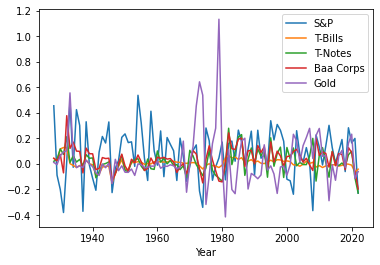

In [11]:
df.plot.line();


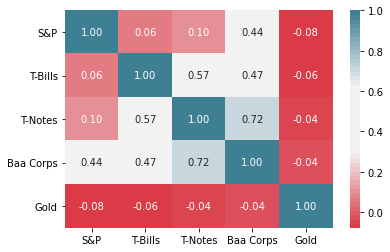

In [12]:
# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [14]:
# drop T-Notes, allocations are small, favors corps 
# df.drop(labels=['T-Notes'], axis=1, inplace=True)
labels = list(df.columns)
labels


['S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold']

# Long-only optimization

In [15]:
df

,S&P,T-Bills,T-Notes,Baa Corps,Gold
Year,,,,,
1928,0.454932,0.042856,0.020148,0.044268,0.011561
1929,-0.088311,0.025602,0.035980,0.024189,-0.005848
1930,-0.200079,0.116932,0.116835,0.074090,0.063953
1931,-0.380674,0.128213,0.074522,-0.070178,0.093168
1932,0.018184,0.126429,0.212472,0.377411,0.102740
...,...,...,...,...,...
2018,-0.060220,0.000257,-0.018907,-0.045852,-0.028397
2019,0.282803,-0.002177,0.071863,0.127529,0.161472
2020,0.164373,-0.009937,0.098359,0.089279,0.232526


In [16]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.082703,0.003059,0.018803,0.039114,0.034383
vol,0.195024,0.038355,0.089697,0.089563,0.203529


In [17]:
w

Variable((5,))

In [18]:
Sigma

array([[ 0.03803418,  0.00045325,  0.00168844,  0.0076717 , -0.00310605],
       [ 0.00045325,  0.00147108,  0.00197492,  0.00161778, -0.00050053],
       [ 0.00168844,  0.00197492,  0.00804558,  0.00578051, -0.00065466],
       [ 0.0076717 ,  0.00161778,  0.00578051,  0.00802145, -0.0006397 ],
       [-0.00310605, -0.00050053, -0.00065466, -0.0006397 ,  0.04142417]])

In [19]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [20]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
# round to not get x.xxxxE-22
wts = [float('%0.6f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0.028259,0.925803,-0.0,-0.0,0.045937


In [21]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 441 ms, sys: 4.7 ms, total: 446 ms
Wall time: 444 ms


In [22]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.001352,0.006755,0.036766,0.028326,9.257119e-01,3.774632e-08,5.675939e-08,4.596251e-02
1,1,0.001536,0.012975,0.039193,0.075711,8.076785e-01,1.484428e-07,4.939905e-02,6.721162e-02
2,2,0.001720,0.015854,0.041478,0.088898,7.427346e-01,4.992977e-09,9.317261e-02,7.519515e-02
3,3,0.001905,0.018100,0.043643,0.099208,6.920751e-01,6.915012e-08,1.273053e-01,8.141171e-02
4,4,0.002089,0.020008,0.045706,0.107924,6.490217e-01,4.998250e-09,1.563451e-01,8.670957e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.037297,0.082266,0.193124,0.990954,7.068287e-09,1.184676e-08,3.207979e-08,9.046423e-03
196,196,0.037481,0.082376,0.193601,0.993231,3.596520e-08,6.008441e-08,1.613587e-07,6.768475e-03
197,197,0.037666,0.082486,0.194076,0.995498,1.704891e-08,2.847333e-08,7.626422e-08,4.501649e-03
198,198,0.037850,0.082595,0.194550,0.997754,6.377374e-09,1.061023e-08,2.768640e-08,2.245535e-03


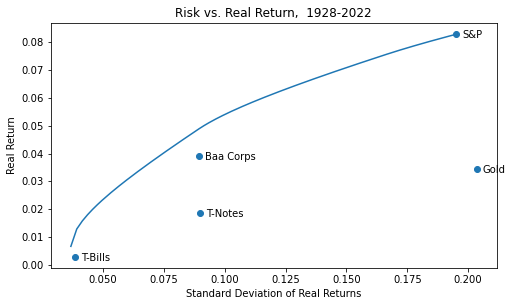

In [23]:
# plot efficient frontier
def plot_efrontier(ret_df, df,
                   xlabel="Standard Deviation of Real Returns",
                   ylabel="Real Return",
                   title=None):

    Sigma = np.cov(df.transpose())
    n = Sigma.shape[0]
    mu = df.mean().values
    asset_vols = np.sqrt(Sigma.diagonal())

    plt.figure(figsize=(8, 4.5))

    # plot the data
    plt.plot(ret_df['std'], ret_df['return'])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plot_title = "Risk vs. Real Return,  %d-%d" % (df.index[0], df.index[-1]) if title is None else title
    plt.title(plot_title)

    # plot the markers
    plt.scatter(asset_vols, mu)
    xoffset = 0.0025
    yoffset = 0.0015
    labels = df.columns
    for i, label in enumerate(labels):
        plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                     horizontalalignment='left', verticalalignment='top',
                    )
        
        
plot_efrontier(ret_df, df)


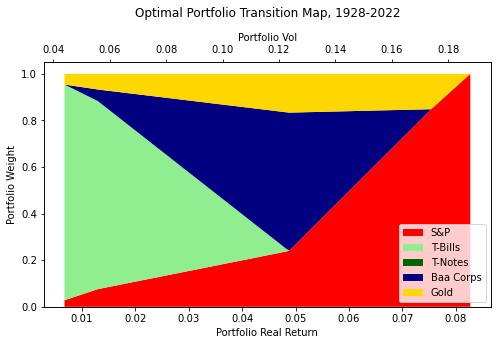

In [24]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df, labels, startyear, endyear):
    
    x = ret_df['return']
    # absolute values so shorts don't create chaos
    y_list = [abs(ret_df[l]) for l in labels]
    pal = ['red', 'lightgreen', 'darkgreen', 'navy', 'gold', 'cyan']
    
    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=labels, colors=pal)
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')
    ax2 = ax1.twiny()
    ax2.set_xlim((ret_df['std'].iloc[0], ret_df['std'].iloc[-1]))
    ax2.set_xlabel('Portfolio Vol')
    
    
    plt.title("Optimal Portfolio Transition Map, %d-%d" % (startyear, endyear), y=1.16);

transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])


## 1972 - present (post gold standard)

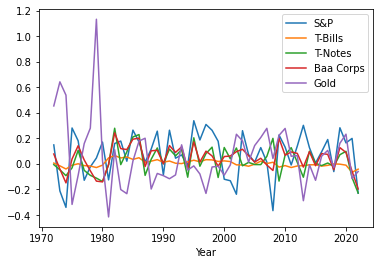

In [25]:
df = data_df.loc[1972:]
df.plot.line();


In [26]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.077076,0.004029,0.025717,0.047959,0.063045
vol,0.171865,0.026286,0.107164,0.094134,0.256768


In [27]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [28]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0.0045,0.9506,-0.0,-0.0,0.0449


In [29]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 492 ms, sys: 5.33 ms, total: 498 ms
Wall time: 497 ms


In [30]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df

,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.000550,0.007012,0.023448,0.004576,9.505491e-01,1.183515e-08,2.303986e-08,4.487464e-02
1,1,0.000695,0.013496,0.026372,0.061194,8.490480e-01,7.719037e-09,1.994387e-02,6.981373e-02
2,2,0.000841,0.016466,0.029003,0.072839,7.921899e-01,5.964610e-09,5.632069e-02,7.865010e-02
3,3,0.000987,0.018829,0.031414,0.082115,7.469524e-01,6.926451e-09,8.525080e-02,8.568157e-02
4,4,0.001132,0.020853,0.033652,0.090049,7.082165e-01,2.888480e-08,1.100346e-01,9.169983e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.028955,0.076973,0.170161,0.992684,9.199851e-10,1.395444e-09,2.931899e-09,7.316062e-03
196,196,0.029101,0.076999,0.170589,0.994528,1.181944e-09,1.784498e-09,3.668182e-09,5.472251e-03
197,197,0.029246,0.077025,0.171015,0.996362,1.593829e-09,2.395247e-09,4.813086e-09,3.638420e-03
198,198,0.029392,0.077050,0.171441,0.998186,2.387970e-09,3.584662e-09,7.083725e-09,1.814407e-03


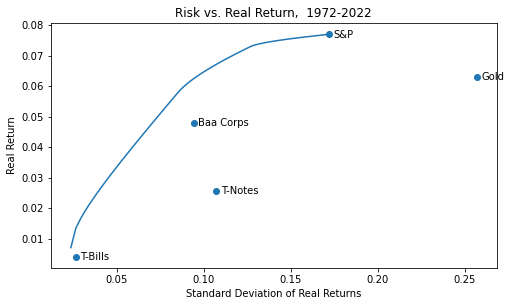

In [31]:
plot_efrontier(ret_df, df)


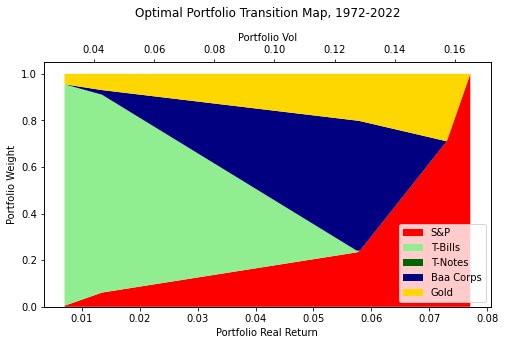

In [32]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

## 1983 - present (post-inflation era)


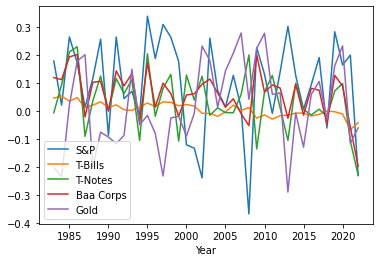

In [33]:
df = data_df.loc[1983:]
df.plot.line();

In [34]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold
rows,,,,,
real return,0.094305,0.005524,0.037455,0.060945,0.017336
vol,0.163317,0.024971,0.102395,0.081568,0.151761


In [35]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights")
pd.DataFrame([wts], columns=labels)


Max return portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,1.0,0.0,0.0,0.0,0.0


In [36]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights")
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights


,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0.0043,0.9331,-0.0,-0.0,0.0626


In [37]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 483 ms, sys: 6.08 ms, total: 489 ms
Wall time: 487 ms


In [38]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold
0,0,0.000523,0.006648,0.022878,0.004324,9.330292e-01,1.420638e-08,3.055975e-08,6.264680e-02
1,1,0.000655,0.013318,0.025590,0.053923,8.376991e-01,1.918237e-08,3.959224e-02,6.878592e-02
2,2,0.000786,0.016593,0.028040,0.061259,7.850719e-01,2.374742e-08,8.749606e-02,6.617282e-02
3,3,0.000918,0.019214,0.030292,0.067111,7.429310e-01,1.477826e-08,1.258517e-01,6.410655e-02
4,4,0.001049,0.021464,0.032389,0.072159,7.067962e-01,1.514554e-08,1.587364e-01,6.230793e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.026147,0.093855,0.161700,0.986527,7.600875e-09,2.501311e-08,1.347265e-02,1.228322e-08
196,196,0.026278,0.093968,0.162106,0.989912,6.783063e-09,2.230826e-08,1.008763e-02,1.095869e-08
197,197,0.026410,0.094081,0.162510,0.993286,1.690119e-08,5.581552e-08,6.713858e-03,2.736591e-08
198,198,0.026541,0.094193,0.162914,0.996649,5.298918e-09,1.674125e-08,3.351406e-03,8.748095e-09


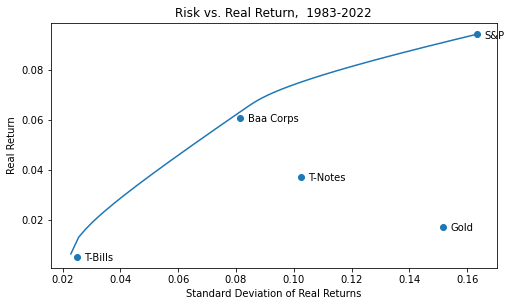

In [39]:
plot_efrontier(ret_df, df)


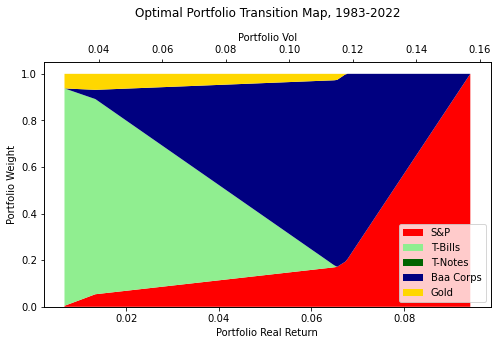

In [40]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])

# Long/short optimization with leverage constraint

In [41]:
x1 = data_df['S&P'].values
n = len(x1)
target_corr = 0.6
theta = np.arccos(target_corr)
mean_return = -0.05
x2 = np.random.normal(0, x1.std(), size=n)  
# center so actual mean = 0
X = pd.DataFrame({'x1': x1 - x1.mean(),
                  'x2': x2 - x2.mean()
                 })
# identity matrix
Id = np.diag(np.ones(n))
# QR factorization 
Q, R = np.linalg.qr(X[['x1']])
P = Q @ Q.T
x2o = (Id - P) @ X[['x2']]
Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
# divide by l2 norm
Y = Xc2 / np.sqrt(np.sum(np.square(Xc2)))
retval = Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return


In [42]:
# in order to include shorts, we need an asset with a poor expected return
# assume I can identify bad stocks, they are highly correlated with S&P but return negative 5%

n = len(data_df)
target_corr = 0.6
def target_corr(x1, target_corr, mean_return):
    """given a series x1, return a random series with correlation target_corr to x1"""
    n = len(x1)
    theta = np.arccos(target_corr)
    
    x2 = np.random.normal(0, x1.std(), size=n)  
    # center so actual mean = 0
    X = pd.DataFrame({'x1': x1 - x1.mean(),
                      'x2': x2 - x2.mean()
                     })
    # identity matrix
    Id = np.diag(np.ones(n))
    # QR factorization
    Q = np.linalg.qr(X[['x1']])[0]
    P = Q @ Q.T
    x2o = (Id - P) @ X[['x2']]
    Xc2 = pd.DataFrame({'x1': X['x1'], 'x2': x2o['x2']})
    # divide by l2 norm
    Y = Xc2 / np.sqrt(np.sum(np.square(Xc2)))
    return Y['x2'] + (1/np.tan(theta)) * Y['x1'] + mean_return

stonks = target_corr(data_df['S&P'].values, 0.9, -0.05)
print("mean return %.04f" % stonks.mean())
print("vol %.04f" % stonks.std())
np.corrcoef(stonks, data_df['S&P'])



mean return -0.0500
vol 0.2366


array([[1. , 0.9],
       [0.9, 1. ]])

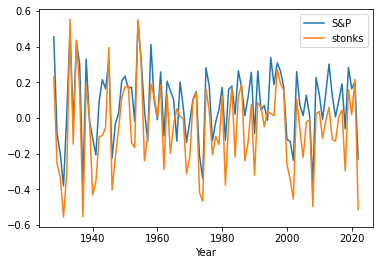

In [43]:
data_df['stonks'] = stonks.to_list()
labels = ['S&P', 'T-Bills', 'T-Notes', 'Baa Corps', 'Gold', 'stonks']

df = data_df
df[['S&P', 'stonks']].plot.line();

In [44]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
# number of assets

n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T @ w 
# volatility
vol = cp.quad_form(w, Sigma)

z = pd.DataFrame([mu, asset_vols], columns=labels)
z['rows'] = ['real return', 'vol']
z.set_index('rows')

,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
rows,,,,,,
real return,0.082703,0.003059,0.018803,0.039114,0.034383,-0.050000
vol,0.195024,0.038355,0.089697,0.089563,0.203529,0.236624


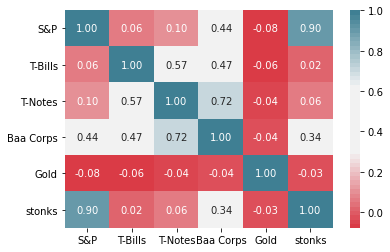

In [45]:
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [46]:
# Solve max return portfolio (corner solution)
# update constraints for leverage scenario
# sum of weights == 1 as before, net long 100%
# remove w >= 0 constraint
# new constraint on gross exposure <= 1.5, otherwise optimal weights are unbounded (go infinity long S&P, infinity short stonks)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
maxretvol = vol.value
maxret = ret.value
print("Max return portfolio weights (return=%.4f, vol=%.4f)" % (maxret, maxretvol))
pd.DataFrame([wts], columns=labels)


Max return portfolio weights (return=0.1159, vol=0.0370)


,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,1.25,-0.0,0.0,0.0,0.0,-0.25


In [47]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]

minvol = vol.value
minvolret = ret.value
print("Min vol portfolio weights (return=%.4f, vol=%.4f)" % (minvolret, minvol))
pd.DataFrame([wts], columns=labels)


Min vol portfolio weights (return=0.0049, vol=0.0013)


,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0.027,1.0161,-0.0853,-0.0059,0.0446,0.0035


In [48]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret), 
                  [cp.norm1(w) <= 1.5,
                   cp.sum(w) == 1,
                   vol <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 529 ms, sys: 8.45 ms, total: 538 ms
Wall time: 535 ms


In [49]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
ret_df


,i,vol,return,std,S&P,T-Bills,T-Notes,Baa Corps,Gold,stonks
0,0,0.001307,0.004882,0.036158,0.027162,1.016016e+00,-8.529612e-02,-5.869646e-03,4.456847e-02,0.003419
1,1,0.001487,0.024441,0.038557,0.181390,9.514139e-01,-6.485151e-02,-5.780935e-03,5.766434e-02,-0.119836
2,2,0.001666,0.032550,0.040815,0.245344,9.246206e-01,-5.630277e-02,-5.804070e-03,6.308995e-02,-0.170948
3,3,0.001845,0.038746,0.042954,0.291347,8.911584e-01,-4.209410e-02,-7.823779e-08,6.749468e-02,-0.207906
4,4,0.002024,0.043822,0.044992,0.328672,8.497523e-01,-1.337351e-02,1.522011e-10,7.157572e-02,-0.236626
...,...,...,...,...,...,...,...,...,...,...
195,195,0.036253,0.115449,0.190403,1.241102,4.609381e-09,8.645966e-09,1.585831e-08,8.898107e-03,-0.250000
196,196,0.036432,0.115557,0.190873,1.243342,4.244799e-09,7.945236e-09,1.440312e-08,6.657717e-03,-0.250000
197,197,0.036612,0.115665,0.191341,1.245572,2.983536e-09,5.491124e-09,9.582897e-09,4.428005e-03,-0.250000
198,198,0.036791,0.115772,0.191809,1.247791,1.003553e-09,1.735325e-09,2.769440e-09,2.208817e-03,-0.250000


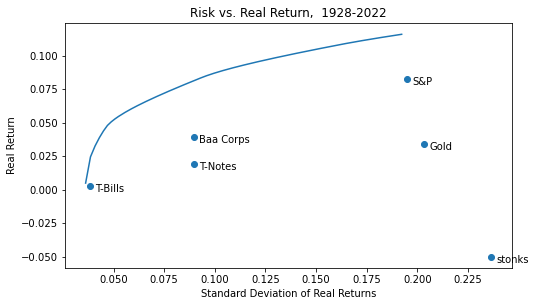

In [50]:
plot_efrontier(ret_df, df)


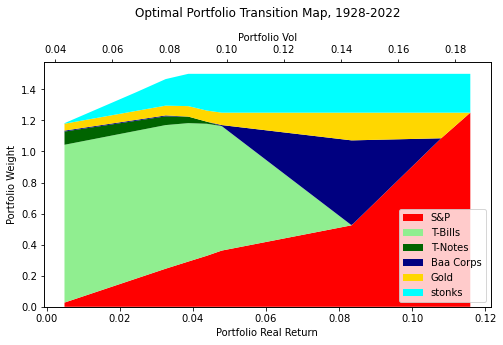

In [51]:
transition_map(ret_df, labels=df.columns, startyear=df.index[0], endyear=df.index[-1])
# these are absolute values, there are shorts

# Factors

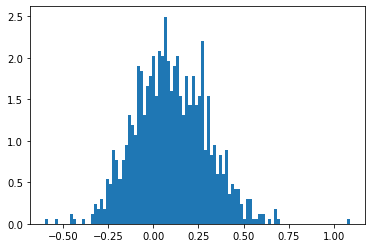

In [52]:
# number of stocks
n = 1000 
# historical mean returns for each stock
mu = np.random.normal(0.1, 0.2, n)

# number of factors
m = 10

# factor covariance matrix - random symmetrical matrix
SigmaFactor = np.random.randn(m, m)/4
SigmaFactor = SigmaFactor.T @ SigmaFactor

# factor loadings, determine volatility and covariances between stocks
F = np.random.randn(n, m)
# idiosyncratic risk of each stock
D = np.diag(np.random.uniform(0, 0.9, size=n))

count, bins, ignored = plt.hist(mu, 100, density=True, align='mid')


In [53]:
w = cp.Variable(n)         # what we solve for: weight for each stock
ret = mu.T @ w             # solve for weights that maximize portfolio return
f = F.T @ w                # portfolio factor loading
Lmax = cp.Parameter()      # leverage constraint
# portfolio volatility: factor risk + idiosyncratic risk
risk = cp.quad_form(f, SigmaFactor) + cp.quad_form(w, D)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])

# Solve the factor model problem.
Lmax.value = 2
prob.solve(verbose=True)

maxretvol = risk.value
maxret = ret.value
print("Max return portfolio (return=%.4f, vol=%.4f)" % (maxret, maxretvol))



ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  -9.828e-02  -3.087e+00  +4e+01  2e-01  6e-01  1e+00  2e-02    ---    ---    1  1  - |  -  - 
 1  -2.140e-01  -1.045e+00  +3e+01  7e-02  3e-01  8e-01  1e-02  0.2887  3e-01   0  0  0 |  0  0
 2  -1.064e+00  -1.920e+00  +3e+01  3e-02  4e-01  1e+00  1e-02  0.0179  1e+00   0  0  0 |  0  0
 3  -1.452e+00  -1.581e+00  +1e+01  5e-03  1e-01  5e-01  6e-03  0.6227  6e-02   0  0  0 |  0  0
 4  -1.487e+00  -1.618e+00  +8e+00  4e-03  9e-02  3e-01  5e-03  0.3177  3e-01   1  1  1 |  0  0
 5  -1.510e+00  -1.642e+00  +8e+00  4e-03  9e-02  3e-01  5e-03  0.0197  9e-01   1  1  0 |  0  0
 6  -1.779e+00  -1.903e+00  +3e+00  1e-03  3e-02  4e-02  2e-03  0.9890  4e-01   1  1  1 |  0  0
 7  -1.922e+00  -1.926e+00  +1e-01  4e-05  1e-03  9e-04  6e-05  0.9722  7e-03   1  1  1 |  0  0
 8  -1.929e+00  -1.929e+00  +1e-03  4e-07  1e-

In [54]:
# solve min vol portfolio (other corner solution)

prob = cp.Problem(cp.Minimize(risk),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax])
prob.solve(solver=cp.OSQP)

minvol = risk.value
minvolret = ret.value
print("Min vol portfolio (return=%.4f, risk=%.4f)" % (minvolret, minvol))


Min vol portfolio (return=0.1376, risk=0.0002)


In [66]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   cp.norm(w, 1) <= Lmax,
                   risk <= vol_limit]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve(verbose=False)
    return (ret.value, np.sqrt(risk.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
results_dict = {}
for vl_val in vl_vals:
    # print(datetime.strftime(datetime.now(), "%H:%M:%S"), vl_val)
    results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
# NPROCESSES = 8
# pool = Pool(processes = NPROCESSES)
# result_values = pool.map(solve_vl, vl_vals)
# results_dict = dict(zip(vl_vals, result_values))


CPU times: user 1min 6s, sys: 1.5 s, total: 1min 7s
Wall time: 8.6 s


In [67]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'var']
ret_df['return'] = [results_dict[v][0] for v in ret_df['var']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['var']]
ret_df


,i,var,return,std
0,0,0.000161,0.165322,0.012779
1,1,0.126278,1.301645,0.355356
2,2,0.252395,1.378043,0.502389
3,3,0.378512,1.425796,0.615233
4,4,0.504629,1.458763,0.710372
...,...,...,...,...
195,195,24.592997,1.927820,4.959133
196,196,24.719114,1.928131,4.971832
197,197,24.845231,1.928441,4.984499
198,198,24.971348,1.928748,4.997134


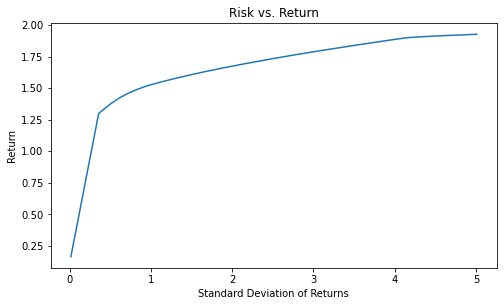

In [68]:
# plot frontier
plt.figure(figsize=(8, 4.5))
#plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Returns")
plt.ylabel("Return")
plt.title("Risk vs. Return")

# plot the data
plt.plot(x,y);


In [69]:
#TRIALS

In [70]:
def trial(vol=0,
          startval=1025000,
          spend=50000,
          ret_expected=0.0,
          vol_expected=0.0, 
          verbose=False):

    year = 0
    val = startval
    while val > 0:
        if verbose:
            print("year %-2d: %8.0f" % (year, val))
        ret = np.random.normal(loc=ret_expected,
                               scale=vol_expected)
        val -= spend
        # lognormal distribution
        val = np.exp(np.log(val) + ret) if val > 0 else 0
        val = max(0, val)
        year += 1

    if verbose:
        print("year %-2d: %8.0f" % (year, val))
        
    return(year)

trial(vol_expected=0.0, verbose=True)


year 0 :  1025000
year 1 :   975000
year 2 :   925000
year 3 :   875000
year 4 :   825000
year 5 :   775000
year 6 :   725000
year 7 :   675000
year 8 :   625000
year 9 :   575000
year 10:   525000
year 11:   475000
year 12:   425000
year 13:   375000
year 14:   325000
year 15:   275000
year 16:   225000
year 17:   175000
year 18:   125000
year 19:    75000
year 20:    25000
year 21:        0


21